In [ ]:
ndtiff_folder = r"C:\Users\MITLENR\..."

In [69]:

given_px_x_um = 0.2 #5x 0.4
given_px_y_um = 0.2 #5x 0.4

In [70]:
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import pyvips
import re
from IPython.display import display
from ndstorage import Dataset
from pathlib import Path
from PIL import Image
from tqdm import tqdm

In [71]:
write_directory = Path(ndtiff_folder)
write_directory

WindowsPath('C:/Users/MITLENR/micro/mm6-pd-tf-10_post/_2')

In [72]:
# Open the dataset
ds = Dataset(ndtiff_folder)

# Convert to numpy array (slow for large datasets; lazy loading is preferred)
images = ds.as_array()

images

Dataset opened                


dask.array<_read_one_image_for_large_array, shape=(282, 1, 1, 1, 2160, 3840, 3), dtype=uint8, chunksize=(1, 1, 1, 1, 2160, 3840, 3), chunktype=numpy.ndarray>

In [98]:
summary = ds.summary_metadata 

stage_positions = summary.get("StagePositions", [])

if len(stage_positions) != len(images):
    raise Exception("Stage positions not the same as number of images. Likely missing some data.")

Exception: Stage positions not the same as number of images. Likely missing some data.

In [73]:
num_zlayers = images.shape[3]
num_zlayers

1

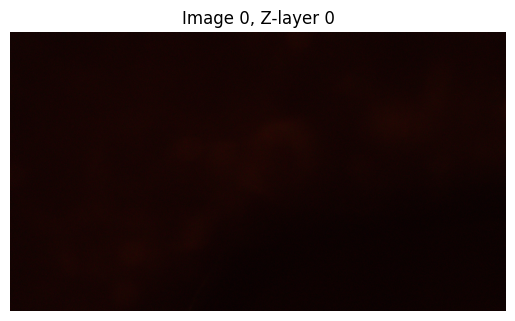

In [74]:
i = 0  # image index

for zlayer in range(num_zlayers):
    
    arr = images[i][0][0][zlayer]

    # Display
    plt.imshow(arr)
    plt.axis("off")
    plt.title(f"Image {i}, Z-layer {zlayer}")
    plt.show()

In [75]:
summary = ds.summary_metadata
print(summary.keys())

dict_keys(['Slices', 'UserData', 'MdaSettings', 'SlicesFirst', 'ProfileName', 'Interval_ms', 'Prefix', 'z-step_um', 'Channels', 'MetadataVersion', 'KeepShutterOpenChannels', 'IntendedDimensions', 'MicroManagerVersion', 'Height', 'PixelType', 'Width', 'Directory', 'Frames', 'UserName', 'TiledImageStorage', 'StartTime', 'AxisOrder', 'StagePositions', 'ChNames', 'KeepShutterOpenSlices', 'ComputerName', 'Positions', 'ChannelGroup', 'TimeFirst'])


In [76]:
with open(write_directory / "summary_metadata.json", "w", encoding="utf-8") as f:
    json.dump(ds.summary_metadata or {}, f, indent=2, ensure_ascii=False, default=str)

In [77]:
# pull µm/px from AffineTransform; falls back if missing
aff = (ds.summary_metadata.get("UserData", {})
                      .get("AffineTransform", {})
                      .get("scalar", ""))

if aff: 
    ax, bx, by, dy = map(float, aff.split("_"))
    px_x_um = (ax*ax + by*by) ** 0.5
    px_y_um = (bx*bx + dy*dy) ** 0.5
else:
    px_x_um, px_y_um = 0, 0

if given_px_x_um and given_px_y_um: 
    px_x_um = given_px_x_um
    px_y_um = given_px_y_um

print(px_x_um)
print(px_y_um)

0.2
0.2


In [78]:
import json, pandas as pd

summary = ds.summary_metadata  # assumes `ds` already open

# --- concise MDA slice parser: always returns >=1 offset ---
def parse_mda_slices(summary):
    # prefer UserData.MDA_Settings.scalar, else MdaSettings
    mda = (summary.get("UserData") or {}).get("MDA_Settings", {})
    mda = mda.get("scalar") if isinstance(mda, dict) else mda
    if not isinstance(mda, str):
        mda = summary.get("MdaSettings") if isinstance(summary.get("MdaSettings"), str) else None

    offsets, relative, zref = None, True, 0.0
    if mda:
        try:
            jd = json.loads(mda)
            off = jd.get("slices")
            if isinstance(off, (list, tuple)) and len(off) > 0:
                offsets = [float(x) for x in off]
            relative = bool(jd.get("relativeZSlice", True))
            zref     = float(jd.get("zReference", 0.0))
        except Exception:
            pass

    if not offsets:
        S = int(summary.get("Slices") or 1)
        S = max(1, S)
        step = None
        if mda:
            try:
                step = float(json.loads(mda).get("sliceZStepUm"))
            except Exception:
                step = None
        if step and S > 1:
            c = (S - 1) / 2.0
            offsets = [(i - c) * step for i in range(S)]
        else:
            offsets = [0.0] * S
    return offsets, relative, float(zref)

def frame_index(pos_idx: int, z_layer: int, S: int) -> int:
    # position-major, z-minor
    return pos_idx * S + z_layer

# --- Stage positions (one per XY position) ---
stage_positions = summary.get("StagePositions", [])
if not stage_positions:
    raise SystemExit("No StagePositions in summary_metadata — cannot build grid.")
P = len(stage_positions)

# --- Z layer info from metadata ---
slice_offsets_um, relative_slices, zref_um = parse_mda_slices(summary)
S = max(1, len(slice_offsets_um))  # ensure at least 1 layer

# --- Tile size (µm / px) ---
width_px  = summary.get("Width")
height_px = summary.get("Height")
tile_w_um = tile_h_um = None
if width_px and height_px and (px_x_um is not None) and (px_y_um is not None):
    tile_w_um = float(width_px)  * float(px_x_um)
    tile_h_um = float(height_px) * float(px_y_um)

# --- Build records (expand positions across Z) ---
records = []
for p, pos in enumerate(stage_positions):
    label    = pos.get("Label", f"Pos-{p}")
    grid_row = pos.get("GridRow")
    grid_col = pos.get("GridCol")

    x_um = y_um = z_base_um = None
    for dev in pos.get("DevicePositions", []):
        if dev.get("Device") == pos.get("DefaultXYStage", "XYStage"):
            xy = dev.get("Position_um", [None, None])
            if isinstance(xy, (list, tuple)) and len(xy) >= 2:
                x_um, y_um = xy[0], xy[1]
        if dev.get("Device") == pos.get("DefaultZStage", "FocusDrive"):
            zu = dev.get("Position_um", [None])
            z_base_um = zu[0] if isinstance(zu, (list, tuple)) else zu

    for z in range(S):
        dz = float(slice_offsets_um[z])  # safe since len == S
        zb = float(z_base_um) if z_base_um is not None else 0.0
        z_abs_um = zb + dz if relative_slices else dz  # add zref_um if your convention needs it
        records.append({
            "Index":       frame_index(p, z, S),
            "PosIndex":    p,
            "Z_layer":     z,
            "Z_offset_um": dz,
            "Z_base_um":   z_base_um,
            "Z_um":        z_abs_um,
            "Label":       label,
            "GridRow":     grid_row,
            "GridCol":     grid_col,
            "X_um":        x_um,
            "Y_um":        y_um,
        })

df = pd.DataFrame(records).sort_values("Index").reset_index(drop=True)

# --- Relative XY (min-subtracted) ---
if not df[["X_um","Y_um"]].isnull().any().any():
    x0, y0 = float(df["X_um"].min()), float(df["Y_um"].min())
    df["X_rel_um"] = df["X_um"] - x0
    df["Y_rel_um"] = df["Y_um"] - y0
else:
    df["X_rel_um"] = pd.NA
    df["Y_rel_um"] = pd.NA

# --- Relative Z (min-subtracted absolute Z) ---
if not df["Z_um"].isnull().any():
    z0 = float(df["Z_um"].min())
    df["Z_rel_um"] = df["Z_um"] - z0
else:
    df["Z_rel_um"] = pd.NA

# --- Tile & pixel sizes on every row ---
df["TileWidth_um"]  = tile_w_um
df["TileHeight_um"] = tile_h_um
df["TileWidth_px"]  = width_px  if width_px  is not None else pd.NA
df["TileHeight_px"] = height_px if height_px is not None else pd.NA
df["PixelSizeX_um"] = px_x_um   if px_x_um   is not None else pd.NA
df["PixelSizeY_um"] = px_y_um   if px_y_um   is not None else pd.NA

df

,Index,PosIndex,Z_layer,Z_offset_um,Z_base_um,Z_um,Label,GridRow,GridCol,X_um,Y_um,X_rel_um,Y_rel_um,Z_rel_um,TileWidth_um,TileHeight_um,TileWidth_px,TileHeight_px,PixelSizeX_um,PixelSizeY_um
0,0,0,0,0.0,16599.820700,16599.820700,Pos-1-000_000,0,0,41865.549342,21748.285632,0.0,0.0,10.632149,768.0,432.0,3840,2160,0.2,0.2
1,1,1,0,0.0,16599.820776,16599.820776,Pos-1-001_000,0,1,42613.549342,21748.285632,748.0,0.0,10.632225,768.0,432.0,3840,2160,0.2,0.2
2,2,2,0,0.0,16599.885251,16599.885251,Pos-1-002_000,0,2,43361.549342,21748.285632,1496.0,0.0,10.696700,768.0,432.0,3840,2160,0.2,0.2
3,3,3,0,0.0,16600.111846,16600.111846,Pos-1-003_000,0,3,44109.549342,21748.285632,2244.0,0.0,10.923295,768.0,432.0,3840,2160,0.2,0.2
4,4,4,0,0.0,16600.607855,16600.607855,Pos-1-004_000,0,4,44857.549342,21748.285632,2992.0,0.0,11.419304,768.0,432.0,3840,2160,0.2,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,385,385,0,0.0,16591.684882,16591.684882,Pos-1-004_025,25,4,44857.549342,32048.285632,2992.0,10300.0,2.496331,768.0,432.0,3840,2160,0.2,0.2
386,386,386,0,0.0,16590.511135,16590.511135,Pos-1-003_025,25,3,44109.549342,32048.285632,2244.0,10300.0,1.322584,768.0,432.0,3840,2160,0.2,0.2
387,387,387,0,0.0,16589.674939,16589.674939,Pos-1-002_025,25,2,43361.549342,32048.285632,1496.0,10300.0,0.486388,768.0,432.0,3840,2160,0.2,0.2
388,388,388,0,0.0,16589.237888,16589.237888,Pos-1-001_025,25,1,42613.549342,32048.285632,748.0,10300.0,0.049337,768.0,432.0,3840,2160,0.2,0.2


In [79]:
csv_path = write_directory / "summary_table.csv"
df.to_csv(csv_path, index=False)
print("✅ Wrote:", csv_path)

✅ Wrote: C:\Users\MITLENR\micro\mm6-pd-tf-10_post\_2\summary_table.csv


In [80]:
if px_x_um and px_y_um: 

    # Collect labels + stage coords (µm)
    xy = []
    for i, pos in enumerate(stage_positions):
        try:
            x_um, y_um = pos["DevicePositions"][0]["Position_um"][:2]
            label = pos.get("Label") or f"Pos-{i:04d}"
            xy.append((label, float(x_um), float(y_um)))
        except Exception:
            continue
    
    # Origin at the minimum stage position
    x0 = min(x for _, x, _ in xy)
    y0 = min(y for _, _, y in xy)
    
    IMG_EXT = ".bmp"  # change to ".png" if that’s what you saved
    tileconf = write_directory / "TileConfiguration.txt"
    
    with open(tileconf, "w", encoding="utf-8") as f:
        f.write("dim = 2\n")
        f.writelines(
            f"{label}{IMG_EXT}; ; ({(x - x0)/px_x_um:.3f}, {(y - y0)/px_y_um:.3f})\n"
            for label, x, y in xy
        )
    
    print("✅ Wrote", tileconf)

✅ Wrote C:\Users\MITLENR\micro\mm6-pd-tf-10_post\_2\TileConfiguration.txt


In [81]:
df_z0 = df.query("Z_layer == 0").sort_values("Index").reset_index(drop=True)
df_z1 = df.query("Z_layer == 1").sort_values("Index").reset_index(drop=True)
df_z2 = df.query("Z_layer == 2").sort_values("Index").reset_index(drop=True)

#df_z0

In [82]:
# Corner lookup via GridRow / GridCol
grmin, grmax = df["GridRow"].min(), df["GridRow"].max()
gcmin, gcmax = df["GridCol"].min(), df["GridCol"].max()

In [83]:
#df.loc[(df["GridRow"]==0) & (df["GridCol"]==0)].iloc[1]

In [84]:
#df.loc[(df["GridRow"]==grmax) & (df["GridCol"]==gcmax)].iloc[1]

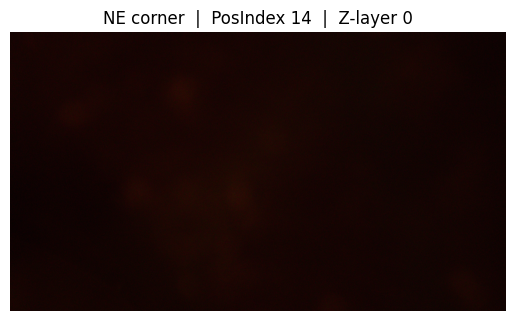

IndexError: Index 389 is out of bounds for axis 0 with size 282

In [85]:
corner_rc = {
    "NW": (grmin, gcmin),
    "NE": (grmin, gcmax),
    "SW": (grmax, gcmin),
    "SE": (grmax, gcmax),
}

# Get one PosIndex per corner (take the first match)
def posindex_at(row, col):
    return int(df.loc[(df["GridRow"]==row) & (df["GridCol"]==col), "PosIndex"].iloc[0])

corner_pos = {name: posindex_at(r, c) for name, (r, c) in corner_rc.items()}

# Already plotted NW; now plot NE, SW, SE
for name in ["NE", "SW", "SE"]:
    i = corner_pos[name]  # PosIndex for this corner
    for zlayer in range(num_zlayers):
        arr = images[i][0][0][zlayer]
        plt.imshow(arr)
        plt.axis("off")
        plt.title(f"{name} corner  |  PosIndex {i}  |  Z-layer {zlayer}")
        plt.show()

In [ ]:
import numpy as np
import plotly.graph_objects as go

# 1) Clean data
cols = ["X_um", "Y_um", "Z_um"]
df_xyz = df.dropna(subset=cols).copy()

# 2) Ranges (min/max define the grid box)
x0, x1 = float(df_xyz["X_um"].min()), float(df_xyz["X_um"].max())
y0, y1 = float(df_xyz["Y_um"].min()), float(df_xyz["Y_um"].max())
z0, z1 = float(df_xyz["Z_um"].min()), float(df_xyz["Z_um"].max())

# 3) Scatter of stage positions
pts = go.Scatter3d(
    x=df_xyz["X_um"],
    y=df_xyz["Y_um"],
    z=df_xyz["Z_um"],
    mode="markers",
    marker=dict(
        size=3,
        opacity=0.9,
        color=df_xyz["Z_um"],          # color by Z for depth cue
        colorscale="Viridis",
        colorbar=dict(title="Z (µm)")
    ),
    hovertemplate=(
        "Index: %{customdata[0]}<br>"
        "Label: %{customdata[1]}<br>"
        "X: %{x:.2f} µm<br>"
        "Y: %{y:.2f} µm<br>"
        "Z: %{z:.2f} µm"
    ),
    customdata=np.stack([
        df_xyz.get("Index", np.arange(len(df_xyz))),
        df_xyz.get("Label", [""]*len(df_xyz))
    ], axis=1)
)

# 4) Bounding box (12 edges)
def box_edges(x0,x1,y0,y1,z0,z1):
    V = [
        (x0,y0,z0),(x1,y0,z0),(x1,y1,z0),(x0,y1,z0),  # bottom (z0)
        (x0,y0,z1),(x1,y0,z1),(x1,y1,z1),(x0,y1,z1)   # top (z1)
    ]
    E = [(0,1),(1,2),(2,3),(3,0), (4,5),(5,6),(6,7),(7,4), (0,4),(1,5),(2,6),(3,7)]
    # concatenate segments with Nones to break lines
    xs, ys, zs = [], [], []
    for a,b in E:
        xs += [V[a][0], V[b][0], None]
        ys += [V[a][1], V[b][1], None]
        zs += [V[a][2], V[b][2], None]
    return go.Scatter3d(
        x=xs, y=ys, z=zs, mode="lines",
        line=dict(color="black", width=2),
        name="Bounds", hoverinfo="skip"
    )

box = box_edges(x0,x1,y0,y1,z0,z1)

# 5) Figure layout (equal axes, nice labels)
fig = go.Figure(data=[pts, box])
fig.update_layout(
    title="Stage Positions (µm)",
    scene=dict(
        xaxis_title="X (µm)",
        yaxis_title="Y (µm)",
        zaxis_title="Z (µm)",
        aspectmode="cube",      # equal scaling on all axes
        xaxis=dict(nticks=6),
        yaxis=dict(nticks=6),
        zaxis=dict(nticks=6),
    ),
    margin=dict(l=0, r=0, t=40, b=0),
    legend=dict(yanchor="top", y=0.98, xanchor="left", x=0.02)
)
fig.show()

In [ ]:
num_firstrectangles = 200
num_lastrectangles  = 200

df_plot = (
    pd.concat([df_z0.head(num_firstrectangles), df_z0.tail(num_lastrectangles)])
      .loc[lambda d: ~d.index.duplicated(keep="first")]
      .copy()
)

#df_plot

In [ ]:
# user controls
num_firstimages = 100
num_lastimages  = 100

df_imgs = (
    pd.concat([df_z0.head(num_firstimages), df_z0.tail(num_lastimages)])
      .loc[lambda d: ~d.index.duplicated(keep="first")]
      .copy()
)

#df_imgs

In [ ]:
px_x_um

In [ ]:
dfv = df_plot

def tile_rgb_from_row(row):
    """Return uint8 RGB tile for the row (H, W, 3). Uses PosIndex/Z_layer if present."""
    if "PosIndex" in row and "Z_layer" in row:
        p = int(row["PosIndex"])
        z = int(row["Z_layer"])
    else:
        # fallback: derive from flattened Index (position-major, z-minor)
        idx = int(row["Index"])
        p, z = divmod(idx, S)

    a = images[p, 0, 0, z]           # (H, W, C) dask -> numpy
    try:
        a = a.compute()
    except Exception:
        pass
    a = np.asarray(a)

    # Normalize to (H, W, 3) uint8
    if a.ndim == 2:
        a = np.repeat(a[..., None], 3, axis=2)
    elif a.shape[-1] == 4:
        a = a[..., :3]
    if a.dtype == np.uint16:
        a = (a >> 8).astype(np.uint8)
    else:
        a = a.astype(np.uint8, copy=False)
    return a

def maybe_downscale(arr, max_side=900):
    """Return arr (H,W,3) possibly downscaled, stays uint8."""
    h, w = arr.shape[:2]
    if max(h, w) <= max_side:
        return arr
    scale = max_side / float(max(h, w))
    new_w = max(1, int(round(w * scale)))
    new_h = max(1, int(round(h * scale)))
    mode = "L" if arr.ndim == 2 else "RGB"
    return np.array(Image.fromarray(arr, mode=mode).resize((new_w, new_h), Image.BILINEAR))

# Vectorized geometry
x0 = dfv["X_rel_um"].to_numpy(float)
y0 = dfv["Y_rel_um"].to_numpy(float)
x1 = (dfv["X_rel_um"] + dfv["TileWidth_um"]).to_numpy(float)
y1 = (dfv["Y_rel_um"] + dfv["TileHeight_um"]).to_numpy(float)
xc = (x0 + x1) / 2
yc = (y0 + y1) / 2
labels = dfv["Label"].astype(str).to_list()

# One-shot shapes + annotations
shapes = [
    dict(type="rect", x0=a, y0=b, x1=c, y1=d, line=dict(width=1, color="black"))
    for a, b, c, d in zip(x0, y0, x1, y1)
]
ann = [
    dict(x=a, y=b, text=t, showarrow=False, font=dict(size=10))
    for a, b, t in zip(xc, yc, labels)
]

fig = go.Figure()

# Invisible trace to set axis limits automatically
fig.add_trace(
    go.Scatter(
        x=[x0.min(), x1.max()],
        y=[y0.min(), y1.max()],
        mode="markers",
        opacity=0,
        showlegend=False,
        hoverinfo="skip",
    )
)

# Minimal layout edits (no per-item updates)
fig.update_layout(
    title="Tiles (0,0 at top-left)",
    shapes=shapes,
    annotations=ann,
    dragmode="zoom",
    height=750,
    margin=dict(l=60, r=20, t=50, b=60),
    plot_bgcolor="white",
)
fig.update_xaxes(title="X (µm)", showgrid=False, ticks="outside",
                 showline=True, mirror=True, zeroline=False)
fig.update_yaxes(title="Y (µm)", showgrid=False, ticks="outside",
                 showline=True, mirror=True, zeroline=False,
                 scaleanchor="x", autorange="reversed")

# --- then add images only for first/last selections ---
for _, r in df_imgs.iterrows():
    arr8 = tile_rgb_from_row(r)                 # <-- robust loader
    arr8 = maybe_downscale(arr8, max_side=900)

    fig.add_layout_image(
        dict(
            source=Image.fromarray(arr8, mode="RGB"),
            x=float(r["X_rel_um"]),
            y=float(r["Y_rel_um"]),
            xref="x", yref="y",
            sizex=float(r["TileWidth_um"]),
            sizey=float(r["TileHeight_um"]),
            xanchor="left", yanchor="top",
            sizing="stretch",
            layer="below",
            opacity=1.0
        )
    )

fig.show()